In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics.functional as metrics

from torch.utils.data import DataLoader
from torchviz import make_dot
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [5]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.0  Device: cpu


In [6]:
train_dataset = datasets.FashionMNIST(root = "../DATA/FashionMNIST",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root = "../DATA/FashionMNIST",
                                train = False,
                                download = True,
                                transform = transforms.ToTensor())

In [7]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../DATA/FashionMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../DATA/FashionMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [10]:
torch.bincount(train_dataset.targets)

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [11]:
test_dataset.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

In [12]:
torch.bincount(test_dataset.targets)

tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

In [13]:
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                          drop_last = True)

test_loader = DataLoader(test_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = False,
                         drop_last = True)

In [14]:
print(f'Train Loader Size => {len(train_loader)}\n')
print(f'Test Loader Size => {len(test_loader)}')

Train Loader Size => 234

Test Loader Size => 39


In [15]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([256, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([256]) type: torch.LongTensor


In [16]:
for (X_test, y_test) in test_loader:
    print('X_test:', X_test.size(), 'type:', X_test.type())
    print('y_test:', y_test.size(), 'type:', y_test.type())
    break

X_test: torch.Size([256, 1, 28, 28]) type: torch.FloatTensor
y_test: torch.Size([256]) type: torch.LongTensor


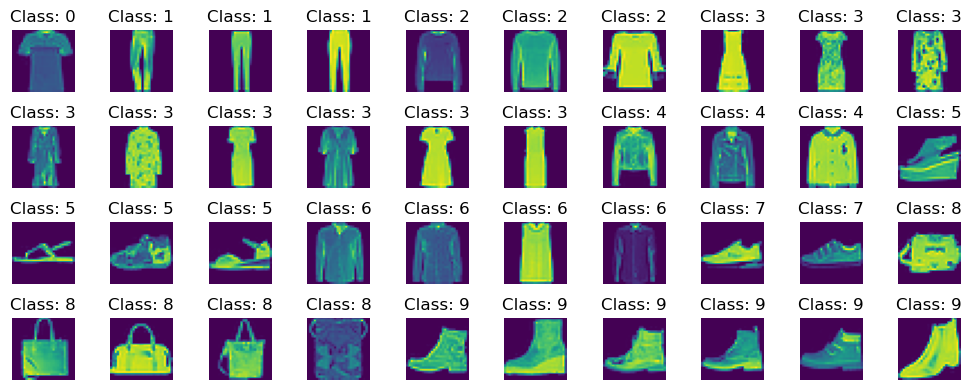

In [17]:
plt.figure(figsize=(10, 4))

labels = np.array([y_train[i].item() for i in range(40)])

for i in np.argsort(labels):
    plt.subplot(4, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[np.argsort(labels)[i]], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[np.argsort(labels)[i]].item()))

plt.tight_layout()
    

In [18]:
class CUSTOM_CNN(nn.Module):
    
    def __init__(self):
        super(CUSTOM_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1))

        self.layer4 = nn.Sequential(
            nn.Linear(4 * 4 * 128, 512),
            nn.ReLU(),
            nn.Dropout())
        
        self.layer5 = nn.Sequential(
            nn.Linear(512, 10))

        self.init_weights()

    def init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                torch.nn.init.kaiming_normal_(layer.weight.data)
                if layer.bias is not None:
                    torch.nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(-1, 4 * 4 * 128)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

In [19]:
MY_MODEL = CUSTOM_CNN().to(DEVICE)
# for _, modelList in model.named_children():
#     for child in modelList:
#         if isinstance(child, nn.Conv2d) or isinstance(child, nn.Linear):
#             nn.init.kaiming_normal_(child.weight)

CLASSES = 10
OPTIMIZER = torch.optim.Adam(MY_MODEL.parameters(), lr = 0.001)
CRITERION = nn.CrossEntropyLoss()
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 5)

In [20]:
print(MY_MODEL)

CUSTOM_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (layer5): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [21]:
for name, parameter in MY_MODEL.named_parameters():
    print(name, parameter)

layer1.0.weight Parameter containing:
tensor([[[[-1.6635e-01, -4.8136e-01,  6.4950e-02],
          [ 6.1313e-01, -5.3385e-01,  5.7607e-01],
          [-6.0227e-01,  9.2300e-03,  3.6338e-01]]],


        [[[-3.6393e-01,  4.2767e-02,  1.6420e-01],
          [ 3.1660e-01, -4.9704e-02,  1.4182e-03],
          [ 1.6846e-02, -6.3563e-01, -2.5533e-01]]],


        [[[ 5.4219e-01,  5.6705e-01,  1.3323e-01],
          [-1.4559e-01,  2.8703e-01, -7.7650e-01],
          [-2.9089e-01, -7.6571e-02, -1.2536e-01]]],


        [[[ 3.9721e-01,  4.1965e-02,  5.4288e-01],
          [-3.4162e-01,  2.1602e-01, -1.8203e-01],
          [ 8.1938e-02,  9.3057e-01,  3.4184e-01]]],


        [[[-1.1380e-01, -1.1931e+00,  1.4286e-01],
          [ 7.0352e-03,  4.2719e-01, -3.5961e-01],
          [-3.2725e-01,  1.2776e-01, -3.9440e-01]]],


        [[[-1.0420e-01,  4.2157e-01, -1.9214e-01],
          [ 1.3575e-01, -1.7962e-01,  2.0757e-03],
          [ 1.0760e+00, -7.0647e-01,  3.4649e-01]]],


        [[[ 3.0770e-

In [22]:
for layer in MY_MODEL.modules():
    print(layer)

CUSTOM_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (layer5): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, pa

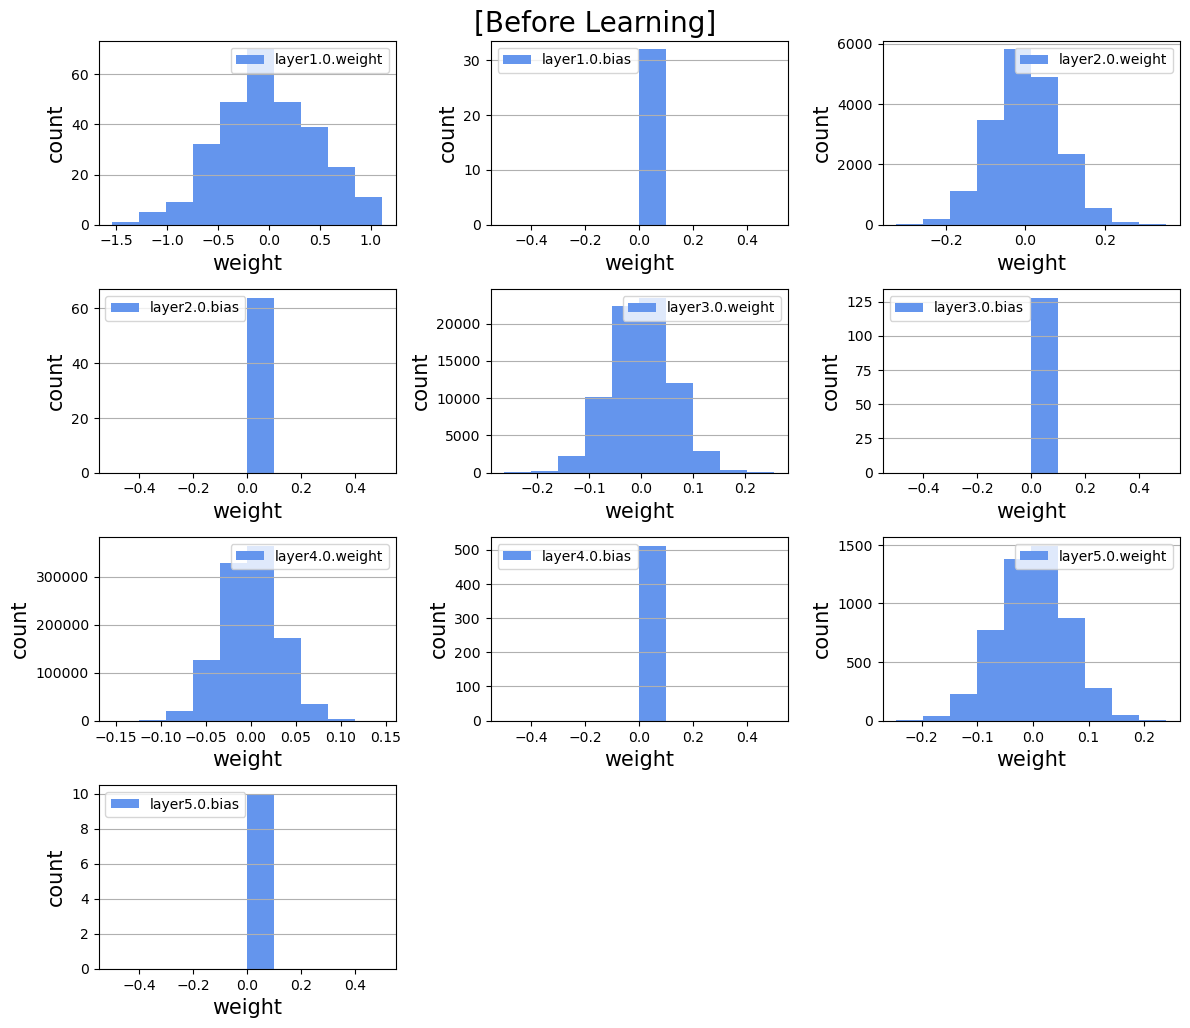

In [23]:
plt.figure(figsize = (12, 15))
plt.suptitle('[Before Learning]', size = 20)
i = 1
for name, params in MY_MODEL.named_parameters():
    plt.subplot(6, 3, i)
    plt.hist(params.detach().numpy().flatten(), label = name, color = 'cornflowerblue')
    plt.xlabel('weight', size = 15)
    plt.ylabel('count', size = 15)
    plt.grid(axis = 'y')
    plt.legend()
    i += 1

plt.tight_layout()
plt.show()

In [24]:
# for name, child in my_model.named_children():
#     for param in child.parameters():
#         plt.hist(param.detach().numpy().flatten(), label = name)
#         plt.xlabel('weight', size = 15)
#         plt.ylabel('count', size = 15)
#         break
# plt.title('[Before Learning]', size = 20)
# plt.grid(axis = 'y')
# plt.legend()
# plt.show()

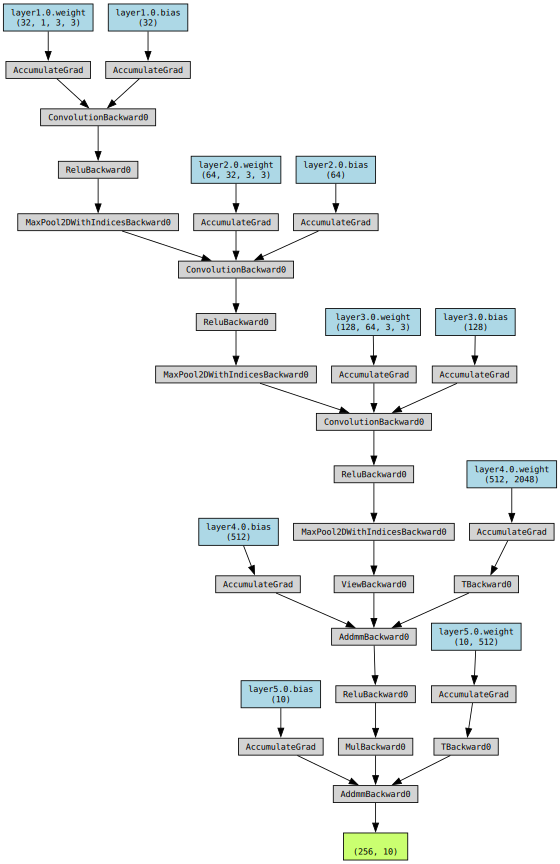

In [25]:
make_dot(MY_MODEL(X_train), params = dict(MY_MODEL.named_parameters()))

In [26]:
### ===> CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(epoch, model, train_loader, optimizer, log_interval):
    
    model.train()
    
    train_loss_list = []
    train_correct_list = []
    train_f1_list = []
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        
        output = model(image)
      
        loss = CRITERION(output, label)
        train_loss_list.append(loss.item())
        
        prediction = output.max(1, keepdim = True)[1]
        correct = prediction.eq(label.view_as(prediction)).sum().item()
        train_correct_list.append(correct)
    
        train_f1score = metrics.f1_score(output, label, task = 'multiclass', num_classes = CLASSES).item()
        train_f1_list.append(train_f1score)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch : {epoch} [{batch_idx}]\tTrain Loss : {loss.item():.6f}\tTrain Accuracy : {prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE:.6f}\tTrain F1 Score : {train_f1score:.6f}")
    
    train_loss = np.mean(train_loss_list)
    train_accuracy = sum(train_correct_list) / len(train_loader.dataset)
    train_f1score = np.mean(train_f1_list)
    
    return train_loss, train_accuracy, train_f1score   

In [27]:
### ===> 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    
    model.eval()

    val_loss_list = []
    val_correct_list = []
    val_f1_list = []
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
    
            output = model(image)
            
            val_loss = CRITERION(output, label)
            val_loss_list.append(val_loss.item())
            
            prediction = output.max(1, keepdim = True)[1]
            correct = prediction.eq(label.view_as(prediction)).sum().item()
            val_correct_list.append(correct)
            
            val_f1score = metrics.f1_score(output, label, task = 'multiclass', num_classes = CLASSES).item()
            val_f1_list.append(val_f1score)
         
    val_loss = np.mean(val_loss_list)
    val_accuracy = sum(val_correct_list) / len(test_loader.dataset)
    val_f1score = np.mean(val_f1_list)
    
    return val_loss, val_accuracy, val_f1score

In [28]:
EPOCHS = 50
loss_list = [[], []]
acc_list = [[], []]
f1_list = [[], []]
for epoch in range(1, EPOCHS + 1):
    
    train_loss, train_accuracy, train_f1_score = train(epoch, MY_MODEL, train_loader, OPTIMIZER, log_interval = 200)
    test_loss, test_accuracy, test_f1_score = evaluate(MY_MODEL, test_loader)
    
    print(f"\n[EPOCH: {epoch}] \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.24f}, \tTrain F1 score : {train_f1_score:.4f}\n")
    print(f"\n[EPOCH: {epoch}] \tValid Loss: {test_loss:.4f}, \tValid Accuracy: {test_accuracy:.4f}, \tValid F1 score : {test_f1_score:.4f}\n")

    loss_list[0].append(train_loss)
    loss_list[1].append(test_loss)
    acc_list[0].append(train_accuracy)
    acc_list[1].append(test_accuracy)
    f1_list[0].append(train_f1_score)
    f1_list[1].append(test_f1_score)
    
    # SCHEDULER.step(test_loss)
    # # 조기종료 기능 => 조건 : test_loss가 지정된 횟수이상 개선이 안되면 학습 종료
    # if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
    #     print(f'Early stopping at epoch {epoch}')
    #     break

Train Epoch : 1 [0]	Train Loss : 2.820446	Train Accuracy : 0.140625	Train F1 Score : 0.140625
Train Epoch : 1 [200]	Train Loss : 0.365652	Train Accuracy : 0.855469	Train F1 Score : 0.855469

[EPOCH: 1] 	Train Loss: 0.5663, 	Train Accuracy: 0.798549999999999982058796, 	Train F1 score : 0.7998


[EPOCH: 1] 	Valid Loss: 0.3572, 	Valid Accuracy: 0.8647, 	Valid F1 score : 0.8661

Train Epoch : 2 [0]	Train Loss : 0.357411	Train Accuracy : 0.867188	Train F1 Score : 0.867188
Train Epoch : 2 [200]	Train Loss : 0.260875	Train Accuracy : 0.906250	Train F1 Score : 0.906250

[EPOCH: 2] 	Train Loss: 0.3244, 	Train Accuracy: 0.880266666666666641738459, 	Train F1 score : 0.8817


[EPOCH: 2] 	Valid Loss: 0.3012, 	Valid Accuracy: 0.8851, 	Valid F1 score : 0.8865

Train Epoch : 3 [0]	Train Loss : 0.204691	Train Accuracy : 0.910156	Train F1 Score : 0.910156
Train Epoch : 3 [200]	Train Loss : 0.337255	Train Accuracy : 0.867188	Train F1 Score : 0.867188

[EPOCH: 3] 	Train Loss: 0.2726, 	Train Accuracy: 0.89

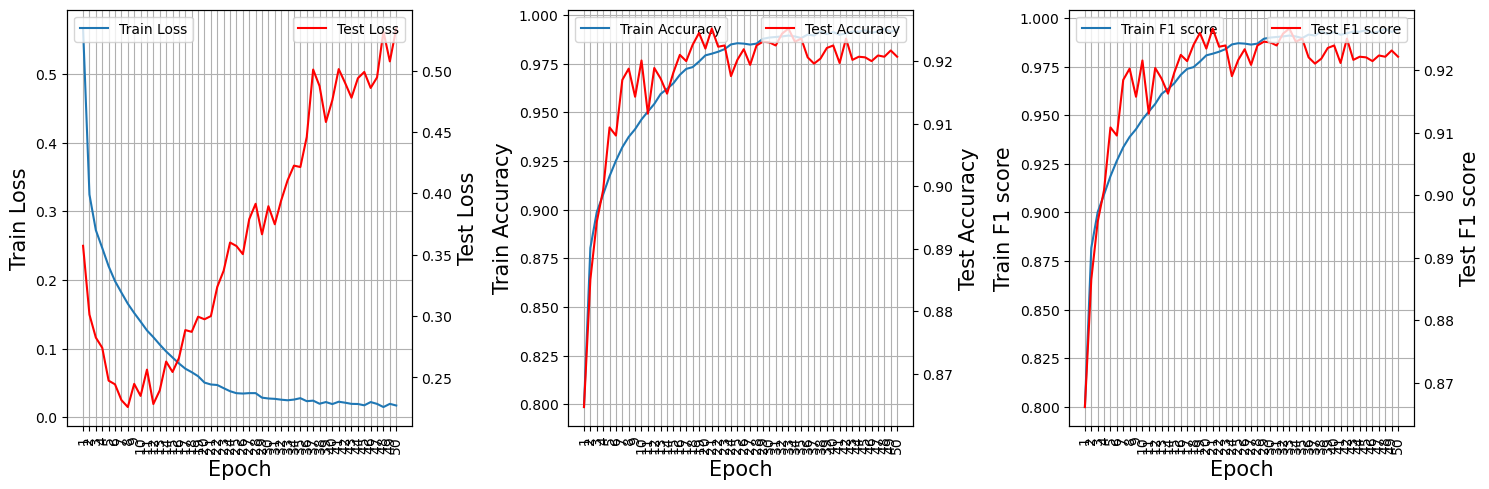

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(loss_list[0], label = "Train Loss")
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Epoch", size = 15)
axes[0].set_ylabel("Train Loss", size = 15)
axes[0].set_xticks(np.arange(EPOCHS))
axes[0].set_xticklabels(np.arange(1, EPOCHS + 1), rotation = 90)
axes[0].grid()
axes2 = axes[0].twinx()
axes2.plot(loss_list[1], label = "Test Loss", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Test Loss", size = 15)

axes[1].plot(acc_list[0], label = "Train Accuracy")
axes[1].legend(loc="upper left")
axes[1].set_xlabel("Epoch", size = 15)
axes[1].set_ylabel("Train Accuracy", size = 15)
axes[1].set_xticks(np.arange(EPOCHS))
axes[1].set_xticklabels(np.arange(1, EPOCHS + 1), rotation = 90)
axes[1].grid()
axes2 = axes[1].twinx()
axes2.plot(acc_list[1], label = "Test Accuracy", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Test Accuracy", size = 15)

axes[2].plot(f1_list[0], label = "Train F1 score")
axes[2].legend(loc="upper left")
axes[2].set_xlabel("Epoch", size = 15)
axes[2].set_ylabel("Train F1 score", size = 15)
axes[2].set_xticks(np.arange(EPOCHS))
axes[2].set_xticklabels(np.arange(1, EPOCHS + 1), rotation = 90)
axes[2].grid()
axes2 = axes[2].twinx()
axes2.plot(f1_list[1], label = "Test F1 score", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Test F1 score", size = 15)
plt.tight_layout()
plt.show()

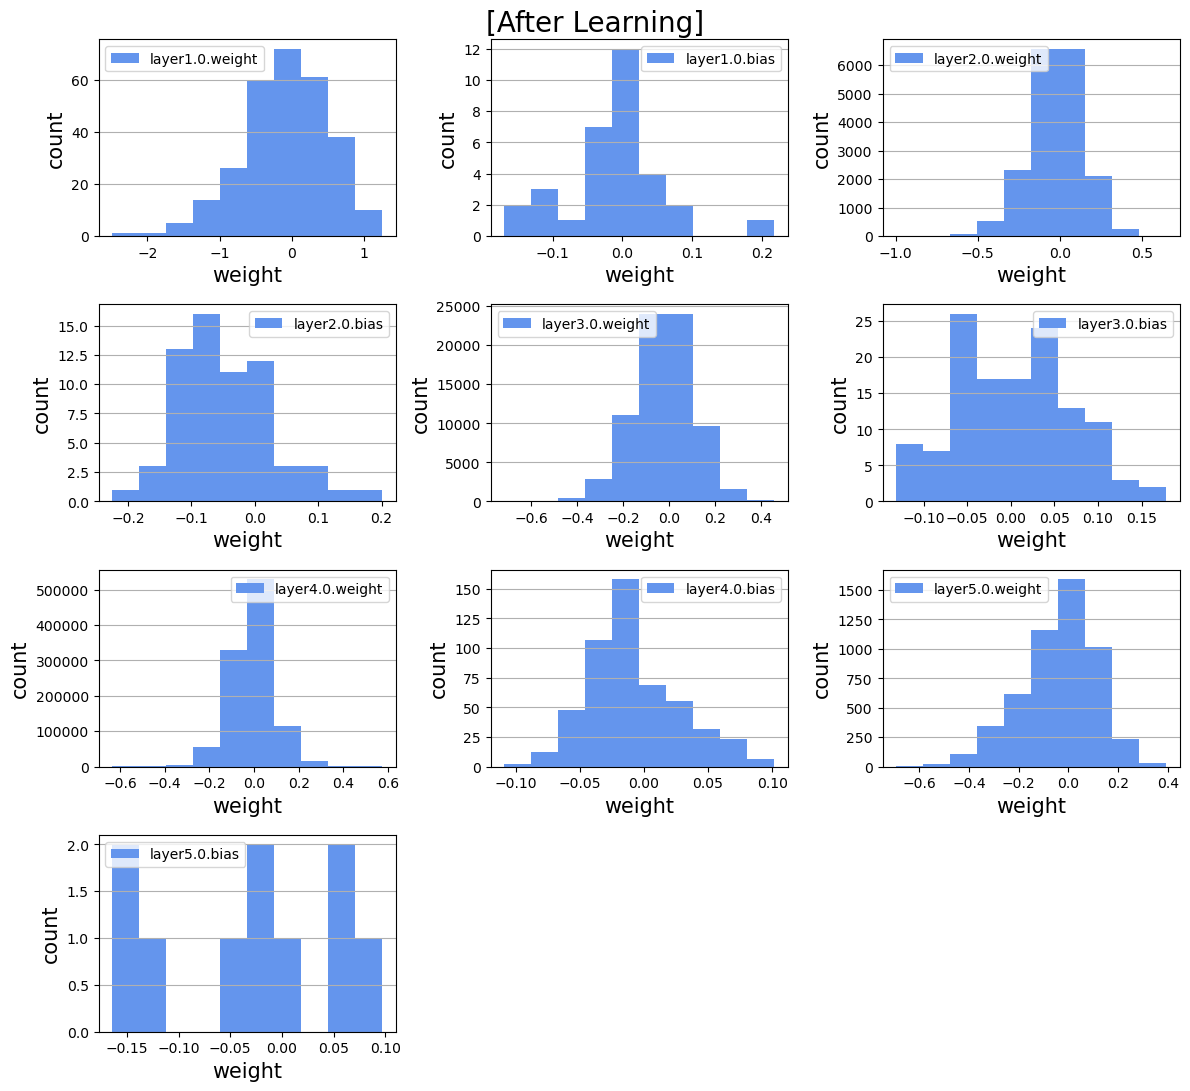

In [32]:
plt.figure(figsize = (12, 16))
plt.suptitle('[After Learning]', size = 20)
i = 1
for name, params in MY_MODEL.named_parameters():
    plt.subplot(6, 3, i)
    plt.hist(params.detach().numpy().flatten(), label = name, color = 'cornflowerblue')
    plt.xlabel('weight', size = 15)
    plt.ylabel('count', size = 15)
    plt.grid(axis = 'y')
    plt.legend()
    i += 1

plt.tight_layout()
plt.show()